# Tuning Regularization in Logistic Regression: From Overfitting to Simplicity

This tutorial explores how L2-regularised logistic regression behaves on a simple two-dimensional synthetic dataset created with `make_classification`.The goal is to show how changing the regularization strength (the parameter `C` in scikit-learn) affects the decision boundary, the model coefficients, and the trade-off between underfitting and overfitting.

By the end of the tutorial, a reader should be able to:
- Explain in plain language what logistic regression does for binary classification.
- Describe what L2 regularization is and how the `C` parameter controls its strength in scikit-learn.
- Interpret plots of train and validation accuracy as `C` varies, in terms of the bias–variance trade-off.
- Visualise and compare decision boundaries for weak vs strong regularization on a 2D dataset.
- Apply these ideas to tune logistic regression models more confidently in their own projects.


## Setup and libraries

In this section, the libraries used throughout the tutorial are imported and a fixed random seed is set. This ensures that the synthetic dataset and all subsequent experiments are reproducible. The key tools are scikit-learn for data generation and logistic regression, and matplotlib for creating clear, accessible visualisations.


## Logistic regression and L2 regularization (theory in brief)

Logistic regression models the probability that a binary label (0 or 1) is 1 given features x by applying the sigmoid function to a weighted sum of the inputs: the model computes a score w^T x + b and then passes it through a squashing function that maps any real number to a value between 0 and 1. The parameters w (weights) and b (bias) are chosen to minimise a loss function based on how well the predicted probabilities match the observed labels on the training data.

L2 regularization adds an extra term to this loss proportional to the sum of squared weights, often written as lambda * ||w||^2, where lambda > 0 controls how strongly large weights are discouraged. In scikit-learn’s LogisticRegression, regularization is handled internally and the hyperparameter C is defined as the inverse of the regularization strength (C = 1 / lambda), so small C means strong regularization and large C means weak regularization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# For nicer plots (colour-blind friendly-ish style)
plt.style.use("seaborn-v0_8-colorblind")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Generating a simple 2D classification problem



In [ ]:
# Generate a simple 2D binary classification dataset
X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,          # separation between classes
    flip_y=0.05,            # a bit of label noise
    random_state=RANDOM_STATE
)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Class balance:", np.bincount(y))


Shape of X: (500, 2)
Shape of y: (500,)
Class balance: [244 256]


To keep the focus on regularization rather than data cleaning, this tutorial uses a synthetic binary classification dataset created with `sklearn.datasets.make_classification`.The dataset contains 500 samples with 2 informative features, no redundant features, and a small amount of label noise so that the classes are mostly but not perfectly separable.

The printed shapes confirm that the feature matrix `X` has 500 rows and 2 columns, and the target vector `y` has 500 labels. The class balance `[244, 256]` shows that the two classes are nearly balanced, which simplifies the interpretation of accuracy scores later on.

### Visualising the raw data

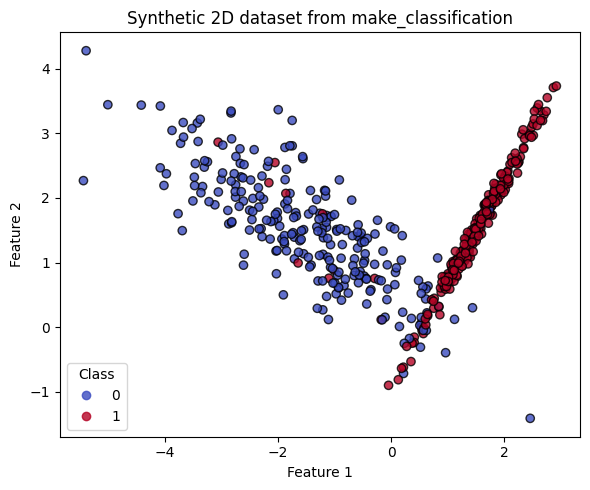

In [ ]:
# Simple scatter plot of the dataset
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap="coolwarm",
    edgecolor="k",
    alpha=0.8
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic 2D dataset from make_classification")
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()



The scatter plot above shows the two-dimensional synthetic dataset, where each point is coloured by its class label. One class forms a tight, almost linear cluster on the right, while the other class is more dispersed on the left, with a small region of overlap between them.

This visualisation helps to see that a linear decision boundary is plausible but not perfect: some points from each class lie in overlapping areas, especially where the clouds approach each other. Later, when regularization is changed, the decision boundary will shift in ways that either ignore or overfit these noisy border points.


## Splitting the data : Train/validation/test split

In [ ]:
# Train/validation/test split: 60% / 20% / 20%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,         # 0.25 of 0.8 = 0.2 of full data
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("Train shape:", X_train.shape, "Class balance:", np.bincount(y_train))
print("Val   shape:", X_val.shape,   "Class balance:", np.bincount(y_val))
print("Test  shape:", X_test.shape,  "Class balance:", np.bincount(y_test))


Train shape: (300, 2) Class balance: [146 154]
Val   shape: (100, 2) Class balance: [49 51]
Test  shape: (100, 2) Class balance: [49 51]


The dataset is split into three parts: 300 samples for training, and two separate sets of 100 samples each for validation and testing. The class balances in all three splits remain close to 50–50, which means that simple accuracy will be a meaningful metric for comparing models in this tutorial.


### Baseline logistic regression (C = 1.0)


In [ ]:
# Baseline logistic regression with standard scaling and C = 1.0
baseline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

baseline_clf.fit(X_train, y_train)

y_train_pred = baseline_clf.predict(X_train)
y_val_pred   = baseline_clf.predict(X_val)
y_test_pred  = baseline_clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val,   y_val_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"Baseline logistic regression (C=1.0)")
print(f"Train accuracy: {train_acc:.3f}")
print(f"Val   accuracy: {val_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")


Baseline logistic regression (C=1.0)
Train accuracy: 0.910
Val   accuracy: 0.910
Test  accuracy: 0.960



A first logistic regression model with standard feature scaling and regularization strength `C = 1.0` achieves 0.910 accuracy on both the training and validation sets, and 0.960 accuracy on the held-out test set. The similar train and validation scores suggest that the model is neither badly overfitting nor severely underfitting at this regularization level, making `C = 1.0` a sensible reference point for further experiments.


## Accuracy vs C loop

In [ ]:
# Grid of C values (inverse regularization strength)
C_values = np.logspace(-3, 3, 13)  # 0.001 ... 1000

results = []

for C in C_values:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2",
            C=C,
            solver="lbfgs",
            max_iter=1000,
            random_state=RANDOM_STATE
        ))
    ])

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred   = clf.predict(X_val)
    y_test_pred  = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val,   y_val_pred)
    test_acc  = accuracy_score(y_test,  y_test_pred)

    results.append((C, train_acc, val_acc, test_acc))

# Convert to a NumPy array for convenience
results = np.array(results, dtype=float)

print("C values:", C_values)
print("Train accuracies:", results[:, 1])
print("Val accuracies:",   results[:, 2])
print("Test accuracies:",  results[:, 3])


C values: [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03]
Train accuracies: [0.80666667 0.89333333 0.9        0.90333333 0.90666667 0.91
 0.91       0.91       0.91       0.91       0.91       0.91
 0.91      ]
Val accuracies: [0.9  0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91]
Test accuracies: [0.86 0.91 0.94 0.95 0.96 0.96 0.96 0.95 0.95 0.95 0.95 0.95 0.95]


## Plot accuracy vs C

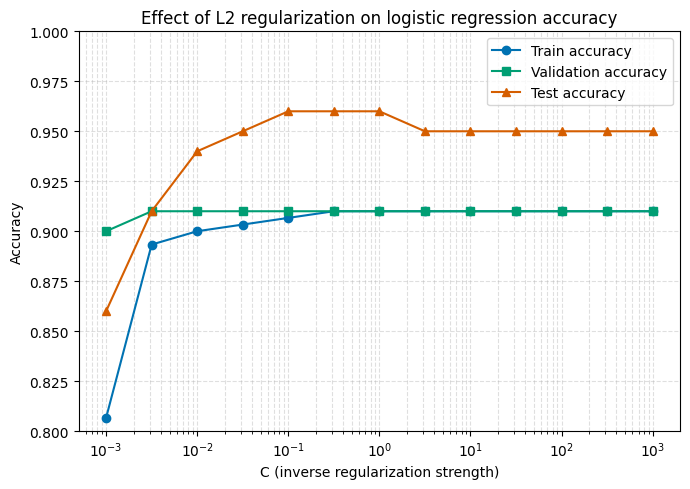

In [ ]:
plt.figure(figsize=(7, 5))

plt.semilogx(C_values, results[:, 1], marker="o", label="Train accuracy")
plt.semilogx(C_values, results[:, 2], marker="s", label="Validation accuracy")
plt.semilogx(C_values, results[:, 3], marker="^", label="Test accuracy")

plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Effect of L2 regularization on logistic regression accuracy")
plt.ylim(0.8, 1.0)
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


### How accuracy changes with regularization strength

The plot shows training, validation, and test accuracy as the regularization parameter `C` varies on a logarithmic scale. With very strong regularization (`C` around 0.001), the model underfits: training accuracy is only about 0.81 and test accuracy is around 0.86, because the coefficients are heavily constrained and the decision boundary is too simple.

As `C` increases from roughly 0.01 to 1, training accuracy rises to about 0.91 and test accuracy peaks near 0.96, while validation accuracy stays stable around 0.91, indicating a good balance between bias and variance in this region. For larger `C` values above 1, weakening regularization further does not improve performance: the three curves remain almost flat, suggesting that the model has already captured the main structure of the data without obvious overfitting on this relatively simple problem.


### Decision boundaries for different regularization strengths

**Helper to plot decision boundary**

In [ ]:
def plot_decision_boundary(ax, clf, X, y, title):
    # Create a grid over the feature space
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # Predict over the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid_points).reshape(xx.shape)

    # Plot decision regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    scatter = ax.scatter(
        X[:, 0], X[:, 1],
        c=y, cmap="coolwarm",
        edgecolor="k",
        s=20
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


**Fit three models with very small / medium / very large C**

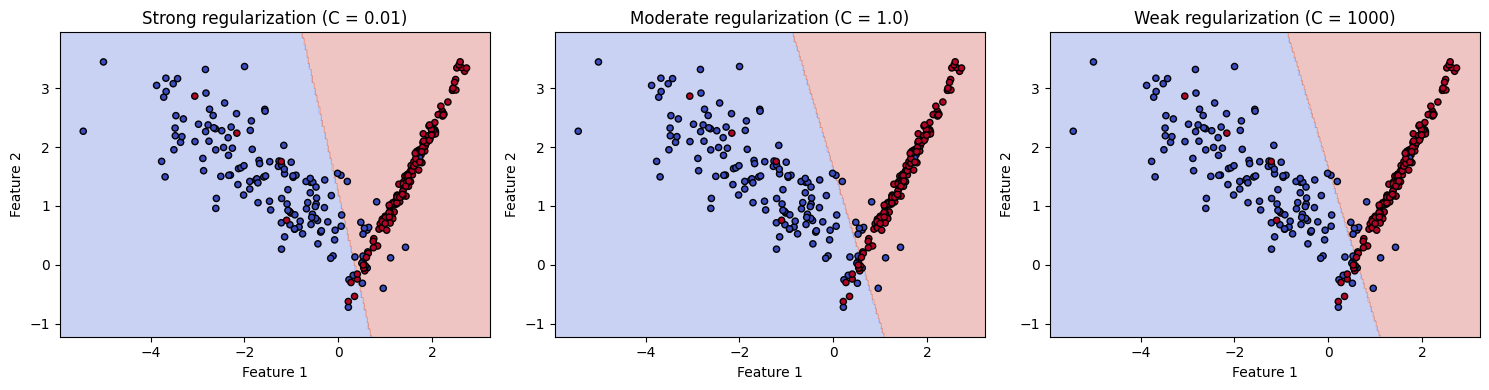

In [ ]:
C_values_visual = [0.01, 1.0, 1000.0]
titles = [
    "Strong regularization (C = 0.01)",
    "Moderate regularization (C = 1.0)",
    "Weak regularization (C = 1000)"
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for C, ax, title in zip(C_values_visual, axes, titles):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2",
            C=C,
            solver="lbfgs",
            max_iter=1000,
            random_state=RANDOM_STATE
        ))
    ])
    clf.fit(X_train, y_train)
    plot_decision_boundary(ax, clf, X_train, y_train, title)

plt.tight_layout()
plt.show()


The three panels compare how the logistic regression decision boundary changes when the regularization parameter `C` is very small (strong regularization), moderate, or very large (weak regularization). With strong regularization (`C = 0.01`), the separating line is almost vertical and ignores many of the fine details of the data, misclassifying several points near the class overlap region because the coefficients are heavily shrunk.

At the moderate setting (`C = 1.0`), the boundary tilts to align more closely with the diagonal structure of the data, correctly classifying most points in both classes while still remaining fairly simple. When regularization is very weak (`C = 1000`), the boundary rotates slightly further towards the training data, picking up a few additional points at the cost of becoming more sensitive to noise and potentially less robust to new samples, even though the change in training accuracy is small on this toy example.



**Track coefficient magnitudes vs C**

In [ ]:
C_values_coeffs = np.logspace(-3, 3, 13)
coef_results = []

for C in C_values_coeffs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2",
            C=C,
            solver="lbfgs",
            max_iter=1000,
            random_state=RANDOM_STATE
        ))
    ])
    clf.fit(X_train, y_train)

    # Get coefficients from the logistic regression step (shape: 1 x 2)
    coefs = clf.named_steps["logreg"].coef_[0]
    coef_results.append((C, coefs[0], coefs[1]))

coef_results = np.array(coef_results, dtype=float)

print("C values:", C_values_coeffs)
print("Coefficients for feature 1:", coef_results[:, 1])
print("Coefficients for feature 2:", coef_results[:, 2])


C values: [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03]
Coefficients for feature 1: [0.10884721 0.30034615 0.69414946 1.29277248 2.02812095 2.7939609
 3.42404049 3.8053494  3.97172392 4.03183004 4.05174009 4.05813248
 4.06016376]
Coefficients for feature 2: [0.0115027  0.03536786 0.0967999  0.20797329 0.35448678 0.50789564
 0.63347167 0.70894067 0.7418298  0.75368793 0.75761359 0.75887375
 0.75927417]


**Plot coefficient size vs C**

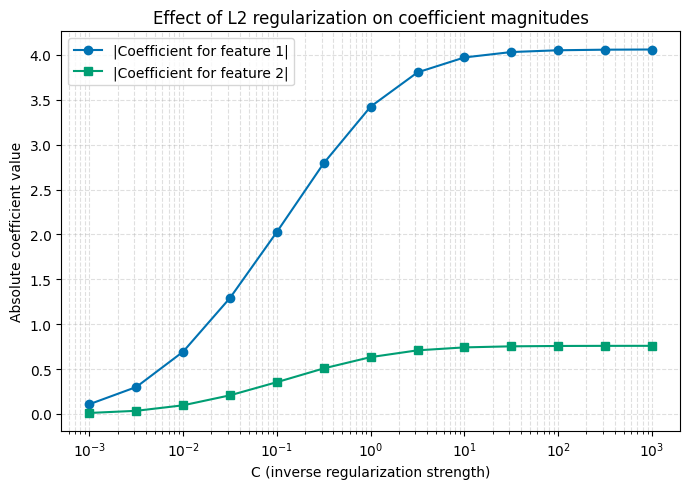

In [ ]:
plt.figure(figsize=(7, 5))

plt.semilogx(C_values_coeffs, np.abs(coef_results[:, 1]),
             marker="o", label="|Coefficient for feature 1|")
plt.semilogx(C_values_coeffs, np.abs(coef_results[:, 2]),
             marker="s", label="|Coefficient for feature 2|")

plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Absolute coefficient value")
plt.title("Effect of L2 regularization on coefficient magnitudes")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


### How regularization shrinks the logistic regression coefficients

The plot shows the absolute values of the two logistic regression coefficients as the regularization parameter `C` varies on a logarithmic scale. For very strong regularization (`C = 0.001`), both coefficients are close to zero (around 0.11 for feature 1 and 0.01 for feature 2), meaning the model places almost no weight on the input features and therefore produces an almost flat decision boundary.

As `C` increases toward 1 and beyond, the penalty becomes weaker, allowing the coefficients to grow in magnitude until they plateau at roughly 4.06 for feature 1 and 0.76 for feature 2. This behaviour illustrates the core idea of L2 regularization: small `C` values enforce simpler models by shrinking weights towards zero, while larger `C` values permit more complex models that can follow the data more closely, at the risk of becoming more sensitive to noise.


## Ethical considerations when tuning logistic regression

Although this tutorial uses a synthetic toy dataset, logistic regression with regularization is widely applied in sensitive domains such as medical diagnosis, hiring, and credit scoring, where each prediction can affect real people. An overfitted model that looks accurate on historical data but generalises poorly can lead to unfair or unsafe decisions, especially if it is trusted because of its apparent simplicity and well-calibrated probabilities.

Carefully tuning the regularization strength `C` on a separate validation set reduces the risk of overfitting, but it does not by itself guarantee fairness or the absence of bias. If the training data reflect historical discrimination, measurement errors, or under-representation of certain groups, a regularised logistic regression model may still reproduce these patterns, so model development should always be combined with critical data checks, domain expertise, and appropriate oversight


## Accessibility choices in this tutorial

All plots in this tutorial use a colour-blind-friendly Matplotlib style and avoid relying solely on colour by combining colour with marker shapes and clear legends. Axis labels and titles describe the meaning of each plot (for example, “Accuracy vs C” or “Effect of L2 regularization on coefficient magnitudes”), making the visualisations easier to interpret for screen-reader users and readers skimming the figures.

In the accompanying written report, each figure will include concise alt text that summarises the main message of the plot in words, such as how accuracy changes with regularization or how the decision boundary moves as `C` varies. This helps readers who cannot see the images clearly to follow the argument and understand the impact of tuning the regularization strength in logistic regression.
